# Heatmaps baltic region precipitation:

## First steps:

At first some python libraries are imported:

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Polygon, Point

The model data is imported as a dataset and large scale and convective precipitation are added together:

In [4]:
large_scale_prec = xr.open_dataset("/students_files/data/slo0043_echam6_code142_mm_1001_8850.ncslo0043_echam6_code142_mm_1001_8850.nc")
convective_prec = xr.open_dataset("/students_files/data/slo0043_echam6_code143_mm_1001_8850.ncslo0043_echam6_code143_mm_1001_8850.nc")
sum_var = large_scale_prec['var142'] + convective_prec['var143']
prec = xr.Dataset({'var260': sum_var})
prec = prec.assign_coords(coords=large_scale_prec.coords)

The longitude and latitude coordinates are adjusted and the dataset is shown:

In [5]:
# adjust values of lon and lat and show dataset

def adjust_lon_lat(ds, lon_name, lat_name, reverse = False):
    """Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude."""
    if reverse == True:
        ds = ds.reindex({lat_name:ds[lat_name][::-1]})
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])
    ds = (ds
          .swap_dims({lon_name: '_longitude_adjusted'})
          .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
          .drop(lon_name))
    ds = ds.rename({'_longitude_adjusted': lon_name})
    return ds
prec = adjust_lon_lat(prec, lon_name="lon", lat_name="lat", reverse=True)

print(prec)

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 192, time: 94200)
Coordinates:
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * time     (time) float64 1.001e+07 1.001e+07 1.001e+07 ... 8.85e+07 8.85e+07
  * lon      (lon) float64 -178.1 -176.2 -174.4 -172.5 ... 176.2 178.1 180.0
Data variables:
    var260   (time, lat, lon) float32 7.13655e-07 7.221388e-07 ... 5.5752316e-06


## Plotting the Baltic region heatmaps:

The baltic region outline is prepared:

In [40]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def subplot_cartopy_nice_baltic(ax):    
    """
    Adjust cartopy plots for the Baltic Sea
    """
    ax.set_aspect("auto")
    ax.coastlines("10m")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.0, linestyle='-')
    gl.top_labels  = False
    gl.left_labels  = True
    gl.right_labels  = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator(list(np.arange(-90, 60, 10)))
    gl.ylocator = mticker.FixedLocator(list(np.arange(-60, 80, 5)))

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Change tick label size
    gl.xlabel_style = {'size': 18}
    gl.ylabel_style = {'size': 18}

    ax.spines['geo'].set_linewidth(5)
    ax.spines['geo'].set_edgecolor('black')
    ax.set_aspect('auto')

Creating a Baltic Sea drainage basin boolean mask:

In [9]:
corner_points = [
    (18.0, 49),
    (23.0, 49),
    (28.0, 55.0),
    (32.0, 56.0),
    (35.0, 62.0),
    (30.0, 62.0),
    (29.0, 67.0),
    (19.0, 68.0),
    (12.0, 61.0),
    (12.0, 57.5),
    (8.0, 56.5),
    (10.0, 53.0),
    (13.5, 52.5)
]

polygon = Polygon(corner_points)

lat_mask = (prec['lat'] >= polygon.bounds[1]) & (prec['lat'] <= polygon.bounds[3])
lon_mask = (prec['lon'] >= polygon.bounds[0]) & (prec['lon'] <= polygon.bounds[2])
mask = (lat_mask & lon_mask)

lat_values = prec['lat'].values
lon_values = prec['lon'].values
for i in range(len(lat_values)):
    for j in range(len(lon_values)):
        if not polygon.contains(Point(lon_values[j], lat_values[i])):
            mask[i, j] = False

At first we want to take a look a the Baltic region mean precipitation:

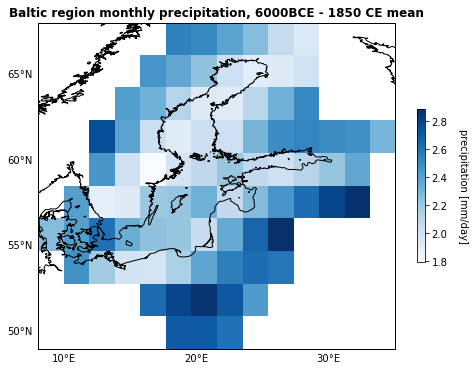

In [12]:
prec_baltic = prec.where(mask)
mean_prec_baltic = prec_baltic.mean(dim=['lat', 'lon'])
mean_prec_baltic -= 273.15
prec_baltic = prec_baltic.sel(lat=slice(49, 68), lon=slice(8, 35))
prec_baltic = prec_baltic * 86400
mean_prec_baltic = prec_baltic.mean(dim=['time'])
mean_prec_baltic = mean_prec_baltic['var260']

# Creating the plot with figsize
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
im = ax.imshow(
    mean_prec_baltic,
    cmap='Blues',
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree() # The data needs to be transformed for the projection 
)

subplot_cartopy_nice_baltic(ax)
ax.spines['geo'].set_linewidth(1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Baltic region monthly precipitation, 6000BCE - 1850 CE mean', fontweight='bold')

cbar = plt.colorbar(im, ax=ax, pad=0.05, shrink=0.47)
cbar.ax.set_ylabel('precipitation [mm/day]', rotation=270, labelpad=20)
plt.show()

Now let's look at the seasonal Baltic mean precipitation:

In [32]:
prec_baltic = prec.where(mask)
prec_baltic = prec_baltic.sel(lat=slice(49, 68), lon=slice(8, 35))
prec_baltic = prec_baltic * 86400
rolling_data = prec_baltic.isel(time=slice(2, None))
seasonal_prec = rolling_data['var260'].rolling(time=3, center=False, min_periods=3).mean()
seasonal_prec = seasonal_prec[2::3]

# Selecting spring data from the rolling_mean dataset as a dataarray
spring_prec = seasonal_prec[0::4]
spring_mean_baltic = spring_prec.mean(dim=['time'])
spring = spring_mean_baltic.mean(dim=['lat','lon'])

# Selecting summer data from the rolling_mean dataset as a dataarray
summer_prec = seasonal_prec[1::4]
summer_mean_baltic = summer_prec.mean(dim=['time'])
summer = summer_mean_baltic.mean(dim=['lat','lon'])

# Selecting fall data from the rolling_mean dataset as a dataarray
fall_prec = seasonal_prec[2::4]
fall_mean_baltic = fall_prec.mean(dim=['time'])
fall = fall_mean_baltic.mean(dim=['lat','lon'])

# Selecting winter data from the rolling_mean dataset as a dataarray
winter_prec = seasonal_prec[3::4]
winter_mean_baltic = winter_prec.mean(dim=['time'])
winter = winter_mean_baltic.mean(dim=['lat','lon'])


print(f"Spring mean prec: {spring}mm/day")
print(f"Summer mean prec: {summer}mm/day")
print(f"Fall mean prec: {fall}mm/day")
print(f"Winter mean prec: {winter}mm/day")

Spring mean prec: <xarray.DataArray ()>
array(1.92921278)mm/day
Summer mean prec: <xarray.DataArray ()>
array(2.75193879)mm/day
Fall mean prec: <xarray.DataArray ()>
array(2.53015093)mm/day
Winter mean prec: <xarray.DataArray ()>
array(2.04838955)mm/day


The following code plots the seasonal mean precipitations in one plot with the same colorbar:

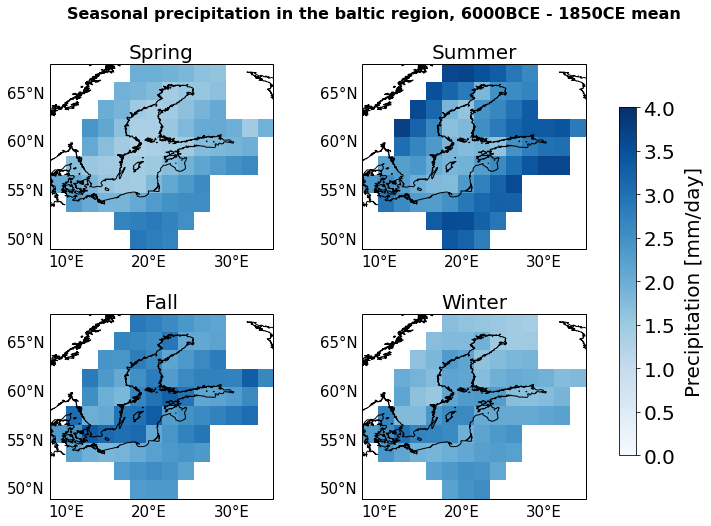

In [36]:
# colorbar range
vmin = 0
vmax = 4

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
fig.subplots_adjust(hspace=0.35, wspace=0.4)

im1 = axs[0,0].imshow(
    spring_mean_baltic,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('Spring', fontsize = '20')

im2 = axs[0,1].imshow(
    summer_mean_baltic,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('Summer', fontsize = '20')

im3 = axs[1,0].imshow(
    fall_mean_baltic,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('Fall', fontsize = '20')

im4 = axs[1,1].imshow(
    winter_mean_baltic,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('Winter', fontsize = '20')

fig.suptitle('Seasonal precipitation in the baltic region, 6000BCE - 1850CE mean', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, shrink=0.8, ax=axs.ravel().tolist())
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Precipitation [mm/day]', fontsize = '20', labelpad=10);

## BA Plots:

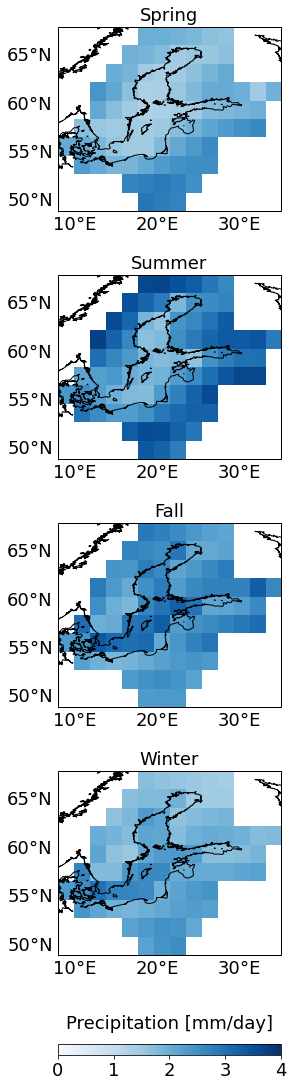

In [41]:
# colorbar range
vmin = 0
vmax = 4

# Create the four plots
fig, axs = plt.subplots(4, 1, figsize=(4, 22), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
fig.subplots_adjust(hspace=0.35, wspace=0.3)

im1 = axs[0].imshow(
    spring_mean_baltic,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0])
axs[0].spines['geo'].set_linewidth(1)
axs[0].set_title('Spring', fontsize = '18')

im2 = axs[1].imshow(
    summer_mean_baltic,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1])
axs[1].spines['geo'].set_linewidth(1)
axs[1].set_title('Summer', fontsize = '18')

im3 = axs[2].imshow(
    fall_mean_baltic,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[2])
axs[2].spines['geo'].set_linewidth(1)
axs[2].set_title('Fall', fontsize = '18')

im4 = axs[3].imshow(
    winter_mean_baltic,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[3])
axs[3].spines['geo'].set_linewidth(1)
axs[3].set_title('Winter', fontsize = '18')

cbar = fig.colorbar(im4, shrink=1, location='bottom', pad=0.074, ax=axs.ravel().tolist())
cbar.ax.tick_params(labelsize=18)
cbar.ax.yaxis.set_label_coords(0.5, 2)
cbar.ax.set_ylabel('Precipitation [mm/day]', fontsize = '18', labelpad=0, rotation=0)
plt.savefig("/students_files/marti/plots/res_04_seas_prec_map", bbox_inches='tight')
plt.show();

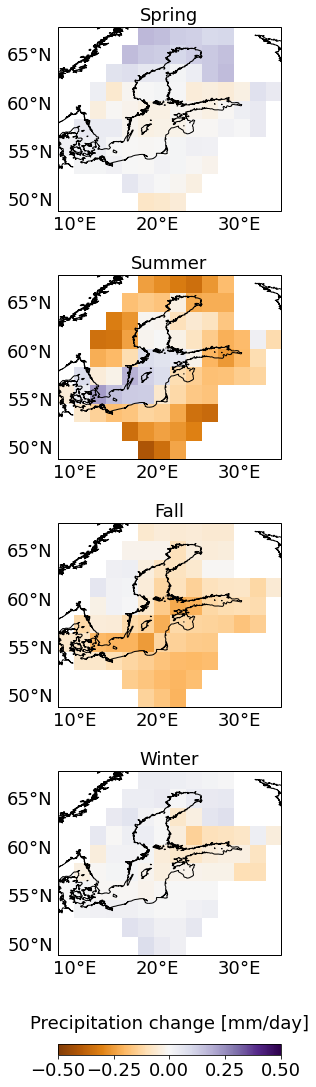

In [42]:
rolling_data = prec_baltic.isel(time=slice(2, None))
rolling_data = rolling_data['var260'].rolling(time=3, center=False, min_periods=3).mean()
seasonal_prec_baltic = rolling_data[2::3]

# Creating spring_prec_baltic DataArray, building mean over last and first 1000 years
spring_prec_baltic = seasonal_prec_baltic[0::4]
spring_prec_baltic.coords['time'] = range(-6000, -6000+len(spring_prec_baltic))
spring_first = spring_prec_baltic.isel(time=slice(0, 1000)).mean(dim=['time']) 
spring_last = spring_prec_baltic.isel(time=slice(6851,7850)).mean(dim=['time'])
spring_diff = spring_last - spring_first

# Creating summer_prec_baltic DataArray, building mean over last and first 1000 years
summer_prec_baltic = seasonal_prec_baltic[1::4]
summer_prec_baltic.coords['time'] = range(-6000, -6000+len(summer_prec_baltic))
summer_first = summer_prec_baltic.isel(time=slice(0, 1000)).mean(dim=['time'])
summer_last = summer_prec_baltic.isel(time=slice(6851,7850)).mean(dim=['time'])
summer_diff = summer_last - summer_first

# Creating fall_prec_baltic DataArray, building mean over last and first 1000 years
fall_prec_baltic = seasonal_prec_baltic[2::4]
fall_prec_baltic.coords['time'] = range(-6000, -6000+len(fall_prec_baltic))
fall_first = fall_prec_baltic.isel(time=slice(0, 1000)).mean(dim=['time'])
fall_last = fall_prec_baltic.isel(time=slice(6851,7850)).mean(dim=['time'])
fall_diff = fall_last - fall_first

# Creating winter_prec_baltic DataArray, building mean over last and first 1000 years
winter_prec_baltic = seasonal_prec_baltic[3::4]
winter_prec_baltic.coords['time'] = range(-6000, -6000+len(winter_prec_baltic))
winter_first = winter_prec_baltic.isel(time=slice(0, 1000)).mean(dim=['time'])
winter_last = winter_prec_baltic.isel(time=slice(6851,7850)).mean(dim=['time'])
winter_diff = winter_last - winter_first

# colorbar range
vmin = -0.5
vmax = 0.5

# Create the four plots
fig, axs = plt.subplots(4, 1, figsize=(4, 22), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
fig.subplots_adjust(hspace=0.35, wspace=0.3)

im1 = axs[0].imshow(
    spring_diff,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0])
axs[0].spines['geo'].set_linewidth(1)
axs[0].set_title('Spring', fontsize = '18')

im2 = axs[1].imshow(
    summer_diff,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1])
axs[1].spines['geo'].set_linewidth(1)
axs[1].set_title('Summer', fontsize = '18')

im3 = axs[2].imshow(
    fall_diff,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[2])
axs[2].spines['geo'].set_linewidth(1)
axs[2].set_title('Fall', fontsize = '18')

im4 = axs[3].imshow(
    winter_diff,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[3])
axs[3].spines['geo'].set_linewidth(1)
axs[3].set_title('Winter', fontsize = '18')

#fig.suptitle('Seasonal precerature changes from model start to end, 1000y mean', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, shrink=1, location='bottom', pad=0.074, ax=axs.ravel().tolist())
cbar.ax.tick_params(labelsize=18)
cbar.ax.yaxis.set_label_coords(0.5, 2)
cbar.ax.set_ylabel('Precipitation change [mm/day]', fontsize = '18', labelpad=0, rotation=0)
plt.savefig("/students_files/marti/plots/res_06_seas_prec_dev_map", bbox_inches='tight')
plt.show();